In [1]:
import io
import os
import pathlib
import requests
import tarfile

import hyperopt
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import sparse
from sklearn import dummy, ensemble, feature_extraction, metrics, model_selection, pipeline, preprocessing, tree
import xgboost as xgb
import yellowbrick
from yellowbrick.model_selection import learning_curve



In [2]:
DATA_ARCHIVE = "https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz"
DATA_DIR = pathlib.Path("./sample_data")

response = requests.get(DATA_ARCHIVE, stream=True)
with tarfile.open(fileobj=response.raw, mode="r|gz") as t:
    t.extractall(DATA_DIR)


In [3]:
def _reviews_to_df(filepath, sentiment):
    d = {"text": [], "sentiment": []}
    review_filepaths = sorted(filepath.glob("*.txt"))
    for review_filepath in review_filepaths:
        with open(review_filepath, 'r') as f:
            review = f.read()
        d["text"].append(review)
        d["sentiment"].append("positive" if sentiment == "pos" else "negative")
    df = pd.DataFrame.from_dict(d)
    return df


def _combine_reviews():
    dfs = []
    for split in ["train", "test"]:
        for sentiment in ["pos", "neg"]:
            df = _reviews_to_df(DATA_DIR / "aclImdb" / split / sentiment, sentiment)
            dfs.append(df)
    combined_df = pd.concat(dfs, ignore_index=True)
    return combined_df


def partition_reviews(seed=42, test_size=0.2):
    combined_df = _combine_reviews()
    random_state = np.random.RandomState(seed)
    train_df, _val_df = model_selection.train_test_split(
        combined_df,
        random_state=random_state,
        shuffle=True,
        stratify=combined_df["sentiment"],
        test_size=test_size
    )

    # split the _val_df equally into val and test sets
    val_df, test_df = model_selection.train_test_split(
        _val_df,
        random_state=random_state,
        shuffle=True,
        stratify=_val_df["sentiment"],
        test_size=0.5
    )

    return train_df, val_df, test_df


In [4]:
train_df, val_df, test_df = partition_reviews(seed=42)

In [5]:
vectorizer_hyperparams = {
    "lowercase": True,
    "max_df": 0.9, # ignore words that show up in more than 90% of reviews
    "min_df": 0.1, # ignore words than show up in less than 10% of reviews
    "norm": "l2", # normalize rows using
    "dtype": np.float32,
}

features_preprocessing = pipeline.make_pipeline(
    feature_extraction.text.TfidfVectorizer(
        **vectorizer_hyperparams,
    ),
    preprocessing.FunctionTransformer(lambda csr: csr.toarray(), lambda arr: sparse.csr_matrix(arr))
)

label_encoder = preprocessing.LabelEncoder()

In [6]:
X_train = features_preprocessing.fit_transform(train_df.loc[:, "text"])
y_train = label_encoder.fit_transform(train_df.loc[:, "sentiment"])

X_val = features_preprocessing.transform(val_df.loc[:, "text"])
y_val = label_encoder.fit_transform(val_df.loc[:, "sentiment"])

X_test = features_preprocessing.transform(test_df.loc[:, "text"])
y_test = label_encoder.fit_transform(test_df.loc[:, "sentiment"])


In [9]:
learning_curve?

ERROR:root:Exception raised in ColabInspector._getdef
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/google/colab/_inspector.py", line 474, in _getdef
    if v.default != v.empty:
ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()


KeyboardInterrupt: ignored

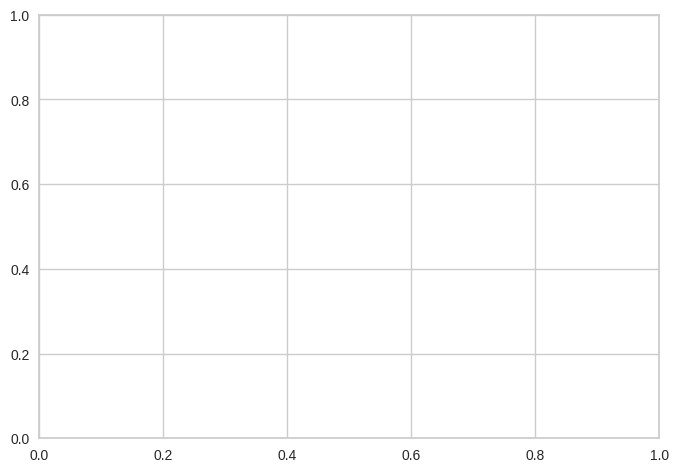

In [8]:
visualizer = learning_curve(
    xgb.XGBClassifier(),
    np.vstack([X_train, X_val]),
    np.hstack([y_train, y_val]),
    train_sizes=np.linspace(1e-1, 1.0, 5),
    cv=3,
    scoring="accuracy",
    n_jobs=-1
)


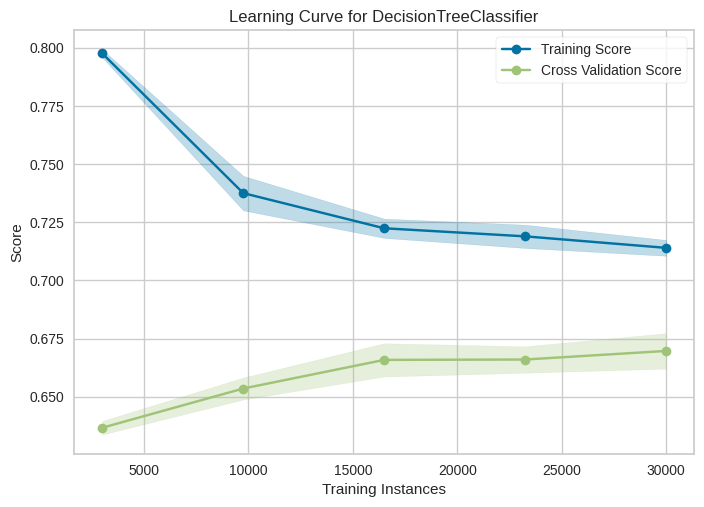

In [10]:
visualizer = learning_curve(
    tree.DecisionTreeClassifier(max_depth=8),
    np.vstack([X_train, X_val]),
    np.hstack([y_train, y_val]),
    train_sizes=np.linspace(1e-1, 1.0, 5),
    cv=3,
    scoring="accuracy",
    n_jobs=-1
)

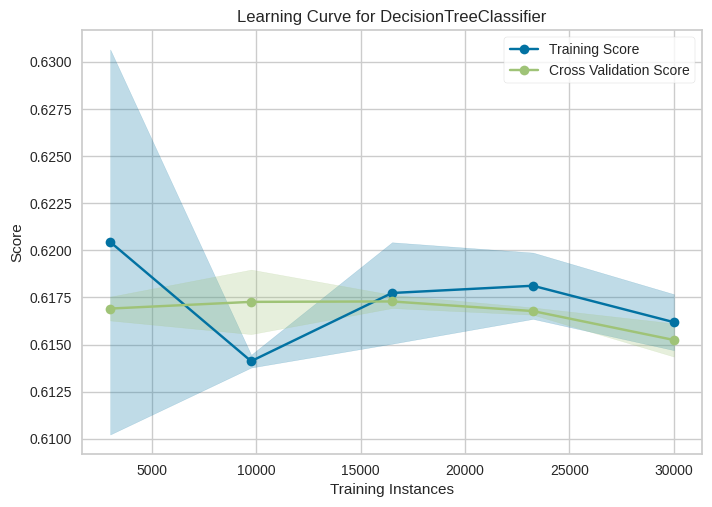

In [11]:
visualizer = learning_curve(
    tree.DecisionTreeClassifier(max_depth=1),
    np.vstack([X_train, X_val]),
    np.hstack([y_train, y_val]),
    train_sizes=np.linspace(1e-1, 1.0, 5),
    cv=3,
    scoring="accuracy",
    n_jobs=-1
)

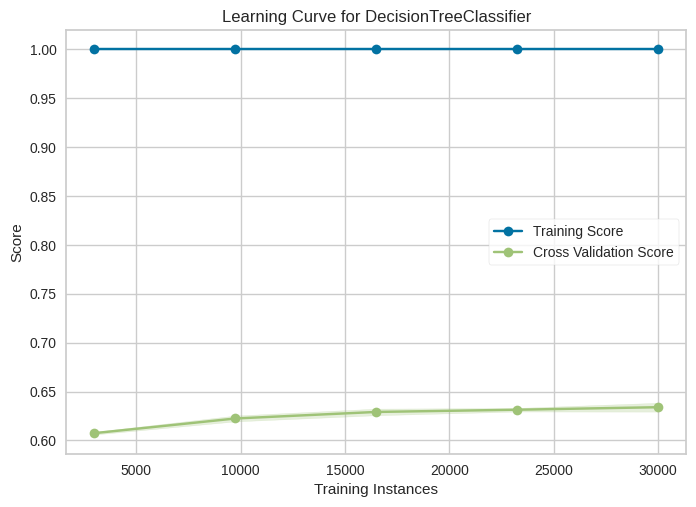

In [12]:
visualizer = learning_curve(
    tree.DecisionTreeClassifier(max_depth=None),
    np.vstack([X_train, X_val]),
    np.hstack([y_train, y_val]),
    train_sizes=np.linspace(1e-1, 1.0, 5),
    cv=3,
    scoring="accuracy",
    n_jobs=-1
)